In [557]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import seaborn as sns
from tqdm import tqdm


# Data Loader

In [535]:
df = pd.read_csv('/home/vydat/Code/ML_AI/Time_Series/Data/features_3_sec.csv')

In [536]:
df.head(5)

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [537]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 9990 non-null   object 
 1   length                   9990 non-null   int64  
 2   chroma_stft_mean         9990 non-null   float64
 3   chroma_stft_var          9990 non-null   float64
 4   rms_mean                 9990 non-null   float64
 5   rms_var                  9990 non-null   float64
 6   spectral_centroid_mean   9990 non-null   float64
 7   spectral_centroid_var    9990 non-null   float64
 8   spectral_bandwidth_mean  9990 non-null   float64
 9   spectral_bandwidth_var   9990 non-null   float64
 10  rolloff_mean             9990 non-null   float64
 11  rolloff_var              9990 non-null   float64
 12  zero_crossing_rate_mean  9990 non-null   float64
 13  zero_crossing_rate_var   9990 non-null   float64
 14  harmony_mean            

In [538]:
df.drop(labels='filename', axis=1, inplace=True)
df.dropna(inplace=True)

In [539]:
x, y = df.iloc[:, :-1], df.iloc[:, -1]

In [540]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

In [561]:
labeled = LabelEncoder()
y_labeled = labeled.fit_transform(y)

In [542]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y_labeled, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15, random_state=42
)

In [543]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, X, y, seq_length=10):
        # Ensure X and y are NumPy arrays
        self.X = torch.FloatTensor(X)  # X is already a NumPy array from scaler
        self.y = torch.LongTensor(y)   # y is already a NumPy array from LabelEncoder
        self.seq_length = seq_length
        
    def __len__(self):
        return len(self.X) - self.seq_length
        
    def __getitem__(self, idx):
        x_seq = self.X[idx:idx + self.seq_length]
        y_target = self.y[idx + self.seq_length - 1]
        return x_seq, y_target

# Create datasets
train_data = CustomDataset(X_train, y_train)
val_data = CustomDataset(X_val, y_val)
test_data = CustomDataset(X_test, y_test)

# Create data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Model 

In [544]:
# --- Parameters for the PyTorch LSTM example ---
INPUT_SIZE_PYTORCH = 58      # Number of input features (matching the actual feature size from data)
HIDDEN_SIZE_PYTORCH = 128    # LSTM hidden state size
NUM_LAYERS_PYTORCH = 2       # Number of LSTM layers
NUM_CLASSES_PYTORCH = 10     # Number of output classes (should match unique labels)
SEQ_LENGTH_PYTORCH = 10      # Sequence length (matching CustomDataset seq_length)
BATCH_SIZE_PYTORCH = 32
NUM_SAMPLES_PYTORCH_TRAIN = 200
NUM_SAMPLES_PYTORCH_VAL = 50
LEARNING_RATE_PYTORCH = 0.001
# EPOCHS_PYTORCH = 5 # Keep epochs low for a quick demo

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # batch_first=True means input and output tensors are provided as (batch, seq, feature)
        # bidirectional=True makes it a Bi-LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True, bidirectional=True)
        # LSTM output is (batch, seq, num_directions * hidden_size)
        # We use hidden_size*2 because it's bidirectional
        self.fc = nn.Linear(hidden_size*2, num_classes)

    def forward(self, x):
        # Initialize hidden and cell states
        # (num_layers * num_directions, batch, hidden_size)
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        # out[:, -1, :] selects the output of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [545]:
# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(np.unique(y_labeled))  # Correct number of classes
model = LSTMModel(input_size=INPUT_SIZE_PYTORCH,
                  hidden_size=HIDDEN_SIZE_PYTORCH,
                  num_layers=NUM_LAYERS_PYTORCH,
                  num_classes=NUM_CLASSES_PYTORCH)
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.1)

In [546]:
# Lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
num_epochs = 100
best_val_loss = float('inf')
patience = 10
patience_counter = 0

for epoch in tqdm(range(num_epochs), desc="Training"):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    # Print GPU memory usage
    if torch.cuda.is_available():
        print(f"\nGPU Memory: {torch.cuda.memory_allocated()/1024**2:.1f}MB / {torch.cuda.get_device_properties(0).total_memory/1024**2:.1f}MB")
    
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += batch_y.size(0)
        train_correct += (predicted == batch_y).sum().item()
    
    train_loss = train_loss / len(train_loader)
    train_acc = 100 * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += batch_y.size(0)
            val_correct += (predicted == batch_y).sum().item()
            
    val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Learning rate scheduler
    scheduler.step(val_loss)
    
    current_lr = optimizer.param_groups[0]['lr']
    
    # Print metrics including learning rate
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Learning Rate: {current_lr:.6f}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Training:   0%|          | 0/100 [00:00<?, ?it/s]


GPU Memory: 19.1MB / 3779.2MB


Training:   1%|          | 1/100 [00:00<01:36,  1.03it/s]


Epoch 1/100
Learning Rate: 0.001000
Train Loss: 1.3640, Train Acc: 51.13%
Val Loss: 1.0115, Val Acc: 63.25%

GPU Memory: 25.9MB / 3779.2MB


Training:   2%|▏         | 2/100 [00:02<01:45,  1.08s/it]


Epoch 2/100
Learning Rate: 0.001000
Train Loss: 0.8180, Train Acc: 71.66%
Val Loss: 0.7796, Val Acc: 72.41%

GPU Memory: 25.9MB / 3779.2MB


Training:   3%|▎         | 3/100 [00:03<01:41,  1.04s/it]


Epoch 3/100
Learning Rate: 0.001000
Train Loss: 0.6278, Train Acc: 77.97%
Val Loss: 0.6842, Val Acc: 76.37%

GPU Memory: 25.9MB / 3779.2MB


Training:   4%|▍         | 4/100 [00:04<01:38,  1.03s/it]


Epoch 4/100
Learning Rate: 0.001000
Train Loss: 0.4948, Train Acc: 83.10%
Val Loss: 0.6728, Val Acc: 77.63%

GPU Memory: 25.9MB / 3779.2MB


Training:   5%|▌         | 5/100 [00:05<01:37,  1.03s/it]


Epoch 5/100
Learning Rate: 0.001000
Train Loss: 0.3793, Train Acc: 87.50%
Val Loss: 0.6232, Val Acc: 79.23%

GPU Memory: 25.9MB / 3779.2MB


Training:   6%|▌         | 6/100 [00:06<01:37,  1.03s/it]


Epoch 6/100
Learning Rate: 0.001000
Train Loss: 0.2617, Train Acc: 91.61%
Val Loss: 0.6495, Val Acc: 79.14%

GPU Memory: 25.9MB / 3779.2MB


Training:   7%|▋         | 7/100 [00:07<01:34,  1.02s/it]


Epoch 7/100
Learning Rate: 0.001000
Train Loss: 0.1635, Train Acc: 95.18%
Val Loss: 0.6482, Val Acc: 79.06%

GPU Memory: 25.9MB / 3779.2MB


Training:   8%|▊         | 8/100 [00:08<01:30,  1.02it/s]


Epoch 8/100
Learning Rate: 0.001000
Train Loss: 0.0868, Train Acc: 98.10%
Val Loss: 0.6854, Val Acc: 79.39%

GPU Memory: 25.9MB / 3779.2MB


Training:   9%|▉         | 9/100 [00:09<01:27,  1.04it/s]


Epoch 9/100
Learning Rate: 0.001000
Train Loss: 0.0377, Train Acc: 99.54%
Val Loss: 0.7027, Val Acc: 79.48%

GPU Memory: 25.9MB / 3779.2MB


Training:  10%|█         | 10/100 [00:09<01:25,  1.05it/s]


Epoch 10/100
Learning Rate: 0.001000
Train Loss: 0.0158, Train Acc: 99.96%
Val Loss: 0.7322, Val Acc: 80.40%

GPU Memory: 25.9MB / 3779.2MB


Training:  11%|█         | 11/100 [00:10<01:24,  1.06it/s]


Epoch 11/100
Learning Rate: 0.001000
Train Loss: 0.0073, Train Acc: 100.00%
Val Loss: 0.7658, Val Acc: 80.15%

GPU Memory: 25.9MB / 3779.2MB


Training:  12%|█▏        | 12/100 [00:11<01:25,  1.03it/s]


Epoch 12/100
Learning Rate: 0.001000
Train Loss: 0.0046, Train Acc: 100.00%
Val Loss: 0.7868, Val Acc: 80.32%

GPU Memory: 25.9MB / 3779.2MB


Training:  13%|█▎        | 13/100 [00:12<01:24,  1.03it/s]


Epoch 13/100
Learning Rate: 0.001000
Train Loss: 0.0034, Train Acc: 100.00%
Val Loss: 0.8098, Val Acc: 80.32%

GPU Memory: 25.9MB / 3779.2MB


Training:  14%|█▍        | 14/100 [00:13<01:25,  1.00it/s]


Epoch 14/100
Learning Rate: 0.001000
Train Loss: 0.0026, Train Acc: 100.00%
Val Loss: 0.8268, Val Acc: 80.32%

GPU Memory: 25.9MB / 3779.2MB


Training:  15%|█▌        | 15/100 [00:14<01:23,  1.01it/s]


Epoch 15/100
Learning Rate: 0.001000
Train Loss: 0.0021, Train Acc: 100.00%
Val Loss: 0.8507, Val Acc: 80.07%

GPU Memory: 25.9MB / 3779.2MB


Training:  16%|█▌        | 16/100 [00:15<01:24,  1.00s/it]


Epoch 16/100
Learning Rate: 0.000100
Train Loss: 0.0016, Train Acc: 100.00%
Val Loss: 0.8653, Val Acc: 80.32%

GPU Memory: 25.9MB / 3779.2MB


Training:  17%|█▋        | 17/100 [00:16<01:24,  1.02s/it]


Epoch 17/100
Learning Rate: 0.000100
Train Loss: 0.0013, Train Acc: 100.00%
Val Loss: 0.8693, Val Acc: 80.07%

GPU Memory: 25.9MB / 3779.2MB


Training:  18%|█▊        | 18/100 [00:17<01:20,  1.01it/s]


Epoch 18/100
Learning Rate: 0.000100
Train Loss: 0.0013, Train Acc: 100.00%
Val Loss: 0.8727, Val Acc: 80.32%

GPU Memory: 25.9MB / 3779.2MB


Training:  19%|█▉        | 19/100 [00:18<01:19,  1.01it/s]


Epoch 19/100
Learning Rate: 0.000100
Train Loss: 0.0013, Train Acc: 100.00%
Val Loss: 0.8752, Val Acc: 80.15%

GPU Memory: 25.9MB / 3779.2MB


Training:  20%|██        | 20/100 [00:19<01:17,  1.03it/s]


Epoch 20/100
Learning Rate: 0.000100
Train Loss: 0.0013, Train Acc: 100.00%
Val Loss: 0.8772, Val Acc: 80.15%

GPU Memory: 25.9MB / 3779.2MB


Training:  21%|██        | 21/100 [00:20<01:17,  1.02it/s]


Epoch 21/100
Learning Rate: 0.000100
Train Loss: 0.0012, Train Acc: 100.00%
Val Loss: 0.8799, Val Acc: 80.07%

GPU Memory: 25.9MB / 3779.2MB


Training:  22%|██▏       | 22/100 [00:21<01:13,  1.06it/s]


Epoch 22/100
Learning Rate: 0.000100
Train Loss: 0.0012, Train Acc: 100.00%
Val Loss: 0.8822, Val Acc: 79.90%

GPU Memory: 25.9MB / 3779.2MB


Training:  23%|██▎       | 23/100 [00:22<01:11,  1.08it/s]


Epoch 23/100
Learning Rate: 0.000100
Train Loss: 0.0012, Train Acc: 100.00%
Val Loss: 0.8852, Val Acc: 80.15%

GPU Memory: 25.9MB / 3779.2MB


Training:  24%|██▍       | 24/100 [00:23<01:09,  1.10it/s]


Epoch 24/100
Learning Rate: 0.000100
Train Loss: 0.0011, Train Acc: 100.00%
Val Loss: 0.8887, Val Acc: 80.15%

GPU Memory: 25.9MB / 3779.2MB


Training:  25%|██▌       | 25/100 [00:24<01:08,  1.10it/s]


Epoch 25/100
Learning Rate: 0.000100
Train Loss: 0.0011, Train Acc: 100.00%
Val Loss: 0.8927, Val Acc: 80.07%

GPU Memory: 25.9MB / 3779.2MB


Training:  26%|██▌       | 26/100 [00:25<01:06,  1.11it/s]


Epoch 26/100
Learning Rate: 0.000100
Train Loss: 0.0010, Train Acc: 100.00%
Val Loss: 0.8964, Val Acc: 80.07%

GPU Memory: 25.9MB / 3779.2MB


Training:  27%|██▋       | 27/100 [00:26<01:05,  1.11it/s]


Epoch 27/100
Learning Rate: 0.000010
Train Loss: 0.0010, Train Acc: 100.00%
Val Loss: 0.8995, Val Acc: 80.24%

GPU Memory: 25.9MB / 3779.2MB


Training:  28%|██▊       | 28/100 [00:27<01:05,  1.10it/s]


Epoch 28/100
Learning Rate: 0.000010
Train Loss: 0.0010, Train Acc: 100.00%
Val Loss: 0.9001, Val Acc: 80.24%

GPU Memory: 25.9MB / 3779.2MB


Training:  29%|██▉       | 29/100 [00:27<01:03,  1.12it/s]


Epoch 29/100
Learning Rate: 0.000010
Train Loss: 0.0010, Train Acc: 100.00%
Val Loss: 0.9008, Val Acc: 80.07%

GPU Memory: 25.9MB / 3779.2MB


Training:  30%|███       | 30/100 [00:28<01:02,  1.12it/s]


Epoch 30/100
Learning Rate: 0.000010
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9014, Val Acc: 80.07%

GPU Memory: 25.9MB / 3779.2MB


Training:  31%|███       | 31/100 [00:29<00:58,  1.18it/s]


Epoch 31/100
Learning Rate: 0.000010
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9020, Val Acc: 80.07%

GPU Memory: 25.9MB / 3779.2MB


Training:  32%|███▏      | 32/100 [00:30<00:55,  1.22it/s]


Epoch 32/100
Learning Rate: 0.000010
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9029, Val Acc: 80.07%

GPU Memory: 25.9MB / 3779.2MB


Training:  33%|███▎      | 33/100 [00:31<00:53,  1.26it/s]


Epoch 33/100
Learning Rate: 0.000010
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9036, Val Acc: 80.07%

GPU Memory: 25.9MB / 3779.2MB


Training:  34%|███▍      | 34/100 [00:31<00:51,  1.28it/s]


Epoch 34/100
Learning Rate: 0.000010
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9042, Val Acc: 80.07%

GPU Memory: 25.9MB / 3779.2MB


Training:  35%|███▌      | 35/100 [00:32<00:49,  1.32it/s]


Epoch 35/100
Learning Rate: 0.000010
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9053, Val Acc: 80.07%

GPU Memory: 25.9MB / 3779.2MB


Training:  36%|███▌      | 36/100 [00:33<00:47,  1.33it/s]


Epoch 36/100
Learning Rate: 0.000010
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9062, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  37%|███▋      | 37/100 [00:33<00:46,  1.35it/s]


Epoch 37/100
Learning Rate: 0.000010
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9073, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  38%|███▊      | 38/100 [00:34<00:45,  1.35it/s]


Epoch 38/100
Learning Rate: 0.000001
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9083, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  39%|███▉      | 39/100 [00:35<00:45,  1.35it/s]


Epoch 39/100
Learning Rate: 0.000001
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9084, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  40%|████      | 40/100 [00:36<00:44,  1.35it/s]


Epoch 40/100
Learning Rate: 0.000001
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9085, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  41%|████      | 41/100 [00:36<00:43,  1.35it/s]


Epoch 41/100
Learning Rate: 0.000001
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9087, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  42%|████▏     | 42/100 [00:37<00:42,  1.35it/s]


Epoch 42/100
Learning Rate: 0.000001
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9088, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  43%|████▎     | 43/100 [00:38<00:42,  1.36it/s]


Epoch 43/100
Learning Rate: 0.000001
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9091, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  44%|████▍     | 44/100 [00:39<00:40,  1.39it/s]


Epoch 44/100
Learning Rate: 0.000001
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9092, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  45%|████▌     | 45/100 [00:39<00:39,  1.38it/s]


Epoch 45/100
Learning Rate: 0.000001
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9094, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  46%|████▌     | 46/100 [00:40<00:38,  1.39it/s]


Epoch 46/100
Learning Rate: 0.000001
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9097, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  47%|████▋     | 47/100 [00:41<00:38,  1.39it/s]


Epoch 47/100
Learning Rate: 0.000001
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9100, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  48%|████▊     | 48/100 [00:41<00:37,  1.39it/s]


Epoch 48/100
Learning Rate: 0.000001
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9102, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  49%|████▉     | 49/100 [00:42<00:36,  1.41it/s]


Epoch 49/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9105, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  50%|█████     | 50/100 [00:43<00:34,  1.43it/s]


Epoch 50/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9105, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  51%|█████     | 51/100 [00:44<00:34,  1.41it/s]


Epoch 51/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9106, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  52%|█████▏    | 52/100 [00:44<00:34,  1.39it/s]


Epoch 52/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9106, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  53%|█████▎    | 53/100 [00:45<00:34,  1.38it/s]


Epoch 53/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9106, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  54%|█████▍    | 54/100 [00:46<00:33,  1.38it/s]


Epoch 54/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9107, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  55%|█████▌    | 55/100 [00:46<00:32,  1.37it/s]


Epoch 55/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9107, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  56%|█████▌    | 56/100 [00:47<00:32,  1.37it/s]


Epoch 56/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9107, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  57%|█████▋    | 57/100 [00:48<00:31,  1.38it/s]


Epoch 57/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9108, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  58%|█████▊    | 58/100 [00:49<00:30,  1.38it/s]


Epoch 58/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9108, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  59%|█████▉    | 59/100 [00:49<00:29,  1.38it/s]


Epoch 59/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9109, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  60%|██████    | 60/100 [00:50<00:29,  1.37it/s]


Epoch 60/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9109, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  61%|██████    | 61/100 [00:51<00:28,  1.37it/s]


Epoch 61/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9109, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  62%|██████▏   | 62/100 [00:52<00:28,  1.36it/s]


Epoch 62/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9109, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  63%|██████▎   | 63/100 [00:52<00:27,  1.35it/s]


Epoch 63/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9109, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  64%|██████▍   | 64/100 [00:53<00:26,  1.35it/s]


Epoch 64/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9109, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  65%|██████▌   | 65/100 [00:54<00:25,  1.35it/s]


Epoch 65/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9109, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  66%|██████▌   | 66/100 [00:55<00:24,  1.36it/s]


Epoch 66/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9109, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  67%|██████▋   | 67/100 [00:55<00:24,  1.37it/s]


Epoch 67/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9109, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  68%|██████▊   | 68/100 [00:56<00:23,  1.36it/s]


Epoch 68/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9109, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  69%|██████▉   | 69/100 [00:57<00:22,  1.36it/s]


Epoch 69/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9109, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  70%|███████   | 70/100 [00:58<00:22,  1.34it/s]


Epoch 70/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9109, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  71%|███████   | 71/100 [00:58<00:21,  1.34it/s]


Epoch 71/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9109, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  72%|███████▏  | 72/100 [00:59<00:20,  1.35it/s]


Epoch 72/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9109, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  73%|███████▎  | 73/100 [01:00<00:20,  1.35it/s]


Epoch 73/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9109, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  74%|███████▍  | 74/100 [01:00<00:19,  1.35it/s]


Epoch 74/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9109, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  75%|███████▌  | 75/100 [01:01<00:18,  1.35it/s]


Epoch 75/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9110, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  76%|███████▌  | 76/100 [01:02<00:17,  1.36it/s]


Epoch 76/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9110, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  77%|███████▋  | 77/100 [01:03<00:17,  1.35it/s]


Epoch 77/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9110, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  78%|███████▊  | 78/100 [01:03<00:16,  1.35it/s]


Epoch 78/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9110, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  79%|███████▉  | 79/100 [01:04<00:16,  1.30it/s]


Epoch 79/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9110, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  80%|████████  | 80/100 [01:05<00:15,  1.32it/s]


Epoch 80/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9110, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  81%|████████  | 81/100 [01:06<00:14,  1.34it/s]


Epoch 81/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9110, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  82%|████████▏ | 82/100 [01:06<00:13,  1.37it/s]


Epoch 82/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9110, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  83%|████████▎ | 83/100 [01:07<00:12,  1.37it/s]


Epoch 83/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9110, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  84%|████████▍ | 84/100 [01:08<00:11,  1.37it/s]


Epoch 84/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9110, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  85%|████████▌ | 85/100 [01:09<00:11,  1.36it/s]


Epoch 85/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9110, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  86%|████████▌ | 86/100 [01:09<00:10,  1.36it/s]


Epoch 86/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9110, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  87%|████████▋ | 87/100 [01:10<00:09,  1.36it/s]


Epoch 87/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9110, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  88%|████████▊ | 88/100 [01:11<00:08,  1.39it/s]


Epoch 88/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9110, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  89%|████████▉ | 89/100 [01:11<00:07,  1.40it/s]


Epoch 89/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9110, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  90%|█████████ | 90/100 [01:12<00:07,  1.42it/s]


Epoch 90/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9110, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  91%|█████████ | 91/100 [01:13<00:06,  1.42it/s]


Epoch 91/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9110, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  92%|█████████▏| 92/100 [01:14<00:05,  1.40it/s]


Epoch 92/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9110, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  93%|█████████▎| 93/100 [01:14<00:05,  1.39it/s]


Epoch 93/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9110, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  94%|█████████▍| 94/100 [01:15<00:04,  1.38it/s]


Epoch 94/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9110, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  95%|█████████▌| 95/100 [01:16<00:03,  1.39it/s]


Epoch 95/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9110, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  96%|█████████▌| 96/100 [01:17<00:02,  1.38it/s]


Epoch 96/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9110, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  97%|█████████▋| 97/100 [01:17<00:02,  1.37it/s]


Epoch 97/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9110, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  98%|█████████▊| 98/100 [01:18<00:01,  1.40it/s]


Epoch 98/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9110, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training:  99%|█████████▉| 99/100 [01:19<00:00,  1.38it/s]


Epoch 99/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9110, Val Acc: 79.98%

GPU Memory: 25.9MB / 3779.2MB


Training: 100%|██████████| 100/100 [01:19<00:00,  1.25it/s]


Epoch 100/100
Learning Rate: 0.000000
Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.9110, Val Acc: 79.98%


In [548]:
torch.save(model.state_dict(), '/home/vydat/Code/ML_AI/Time_Series/model.pt')

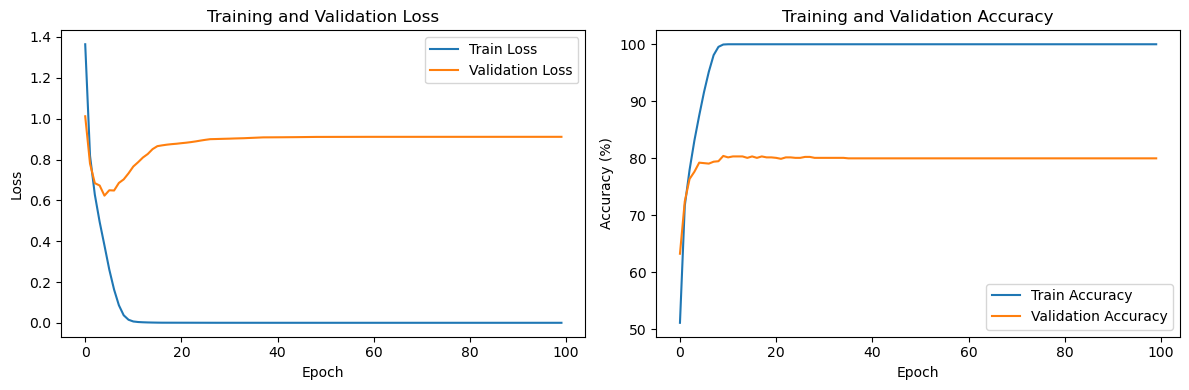

In [549]:
# Plot training and validation metrics
plt.figure(figsize=(12, 4))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracies 
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [554]:
# Load the saved model
model.load_state_dict(torch.load('/home/vydat/Code/ML_AI/Time_Series/model.pt'))
model.to(device)
model.eval()  # Set the model to evaluation mode

# Initialize metrics for test set
test_loss = 0
correct = 0
total = 0

# Disable gradient calculations for testing
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Calculate test loss
        test_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate average test loss and accuracy
test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f"\nTest Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")



Test Results:
Test Loss: 0.7066
Test Accuracy: 83.50%


/tmp/ipykernel_18503/2494982269.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/home/vydat/Code/ML_AI/Time_Series/model.pt'))
